In [436]:
%run ../kdsb_io.py
%run ../utils.py
%run models.py

### Interesting Cases

- 139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5bc3382f8df9355443d (id 33)

In [2]:
import matplotlib.pyplot as plt
from cvutils import visualize
from imgaug import augmenters as iaa
import pandas as pd
plt.gray()
init_session()
data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_train')
meta_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_meta')
model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv(osp.join(meta_dir, 'classes.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
filename      735 non-null object
foreground    735 non-null object
background    735 non-null object
dtypes: object(3)
memory usage: 17.3+ KB


In [4]:
df.groupby(['foreground', 'background']).size()

foreground  background
black       white          16
purple      purple         71
            white          41
            yellow          8
white       black         599
dtype: int64

In [5]:
df_train = df[(df['foreground'] == 'white') & (df['background'] == 'black')]
len(df_train)

599

In [6]:
# Restrict to only files in training data (classes.csv includes train and test)
df_train = df_train[df_train['filename'].apply(lambda f: osp.exists(osp.join(data_dir, f.replace('.png', ''))))]
len(df_train)

546

In [7]:
ids = df_train['filename'].str.replace('.png', '')

In [8]:
list(ids)[:3]

['d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf',
 '4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0',
 'b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1']

In [9]:
# ids = !ls $data_dir | head -n 10
# ids

In [10]:
#t = io.imread(osp.join(data_dir, '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', 'images', '00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'))

In [11]:
target_shape = (256, 256, 1)
X, Y = load_images(data_dir, target_shape, add_boundaries=True, ids=ids)

100%|██████████| 546/546 [01:36<00:00,  5.66it/s]


In [12]:
# Verify that all images are scaled to cover uint8 range
assert np.unique(np.apply_over_axes(np.min, X, [1,2,3]).squeeze())[0] == 0
assert np.unique(np.apply_over_axes(np.max, X, [1,2,3]).squeeze())[0] == 255

# Verify that Y masks are boolean and then convert to uint8
assert Y.dtype == np.bool
Y = Y.astype(np.uint8)

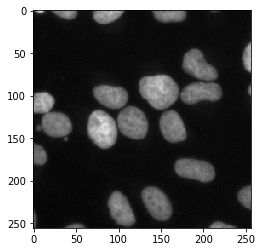

In [606]:
plt.imshow(X[2].squeeze())
#plt.gcf().set_size_inches(12, 12)

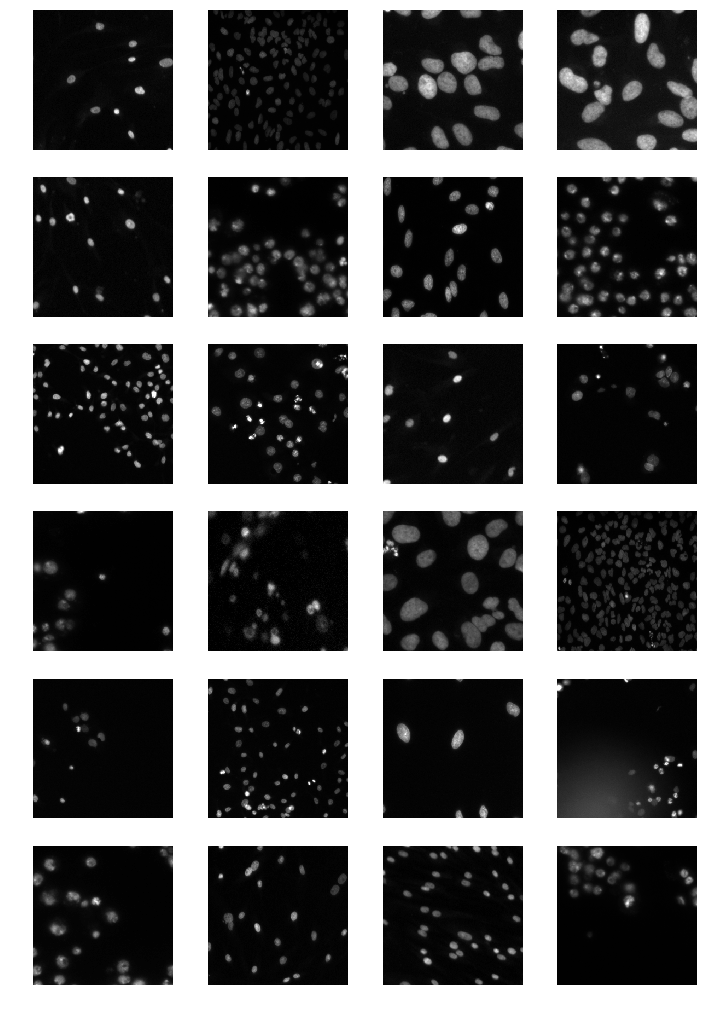

In [14]:
visualize.display_images([X[i, ..., 0] for i in range(0, 24)], size=12)

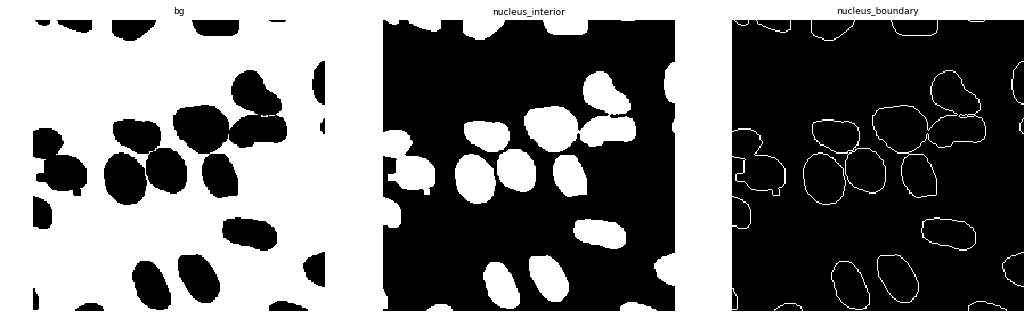

In [608]:
visualize.display_images([Y[2, ..., i] for i in range(Y.shape[-1])], titles=class_names, size=24)

In [609]:
from skimage import morphology

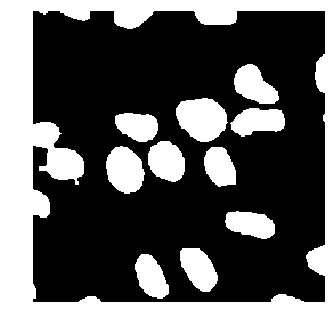

In [617]:
visualize.display_images([morphology.erosion(Y[2, ..., 1], selem=np.ones((3, 3)))], size=24)

In [16]:
X.shape, X.dtype, Y.shape, Y.dtype

((546, 256, 256, 1), dtype('uint8'), (546, 256, 256, 3), dtype('uint8'))

In [500]:
from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=seed)
idx_train, idx_test = train_test_split(np.arange(len(X)), test_size=.25, random_state=seed)
X_train, X_test, Y_train, Y_test = X[idx_train], X[idx_test], Y[idx_train], Y[idx_test]

# Remove bg mask
Y_train = Y_train[...,1:]
Y_test = Y_test[...,1:]
# Y_train = Y_train[...,[2]]
# Y_test = Y_test[...,[2]]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((409, 256, 256, 1),
 (137, 256, 256, 1),
 (409, 256, 256, 2),
 (137, 256, 256, 2))

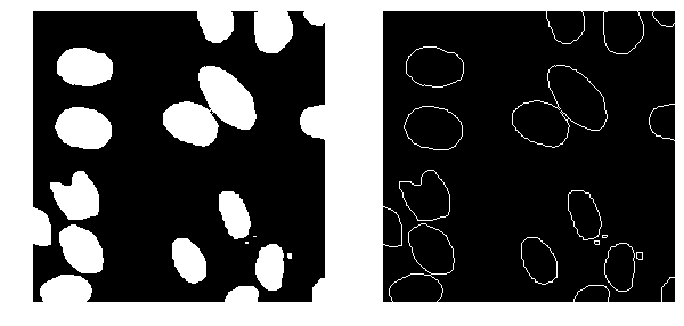

In [352]:
visualize.display_images([Y_test[0, ..., i] for i in range(Y_test.shape[-1])], size=24)

In [513]:
#model = get_model(3, target_shape, p=[5,6,7,8], activation=None)

# unet4nuclei model
# model = get_model(3, target_shape, activation=None, p=[6,7,8,9], batch_norm=True, dropout=None)
# loss = pixelwise_weighted_cross_entropy_loss([1., 5., 10.])

# Nuke model (https://www.kaggle.com/c/data-science-bowl-2018/discussion/54742)
# model = get_model(3, target_shape, activation=None, p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])

# w/ weighted classes
# model = get_model(3, target_shape, activation=None, p=[4,5,6,7,8], batch_norm=False, dropout=None)
# loss = class_weighted_softmax_cross_entropy_loss([1., 5., 10.])

# w/ sigmoid
#model = get_model(2, target_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None)
model = get_model(2, target_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None)
loss = weighted_pixelwise_crossentropy([[[[1., 50.]]]])

#model = get_model(2, target_shape, activation=None, p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])
#loss = keras.losses.binary_crossentropy

#model = get_model(3, target_shape, activation='softmax', p=[4,5,6,7,8], batch_norm=False, dropout=[.1,.1,.2,.2,.3])
#loss = keras.losses.categorical_crossentropy

In [375]:
#loss = class_weighted_sigmoid_cross_entropy_loss([1., 5.])
#loss = keras.losses.binary_crossentropy


In [376]:
# def pixelwise_crossentropy(target, output):
#     _epsilon = 10e-8
#     output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
#     weight = 1. * target[:,:,:,0:1] + 5. * target[:,:,:,1:2] + 10. * target[:,:,:,2:3]
#     return - tf.reduce_sum(target * weight *  tf.log(output) +
#                            (1 - target)  *  tf.log(1 - output),
#                            len(output.get_shape()) - 1)

# def pixelwise_crossentropy(target, output):
#     _epsilon = 10e-8
#     output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
#     weight = 50.
#     return - tf.reduce_mean(target * weight *  tf.log(output) + (1 - target)  *  tf.log(1 - output))

# def pixelwise_crossentropy(target, output):
#     _epsilon = 10e-8
#     output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
#     weight = 1. * target[:,:,:,0:1] + 50. * target[:,:,:,1:2] 
#     return - tf.reduce_mean(target * weight *  tf.log(output) + (1 - target)  *  tf.log(1 - output))

# def pixelwise_crossentropy(target, output):
#     _epsilon = 10e-8
#     output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
#     w = tf.constant([[[[1., 1000.]]]]) 
#     return - tf.reduce_mean(w * (target *  tf.log(output) + (1 - target)  *  tf.log(1 - output)))

#loss = pixelwise_crossentropy

In [377]:
#model.summary()

In [514]:
optimizer = keras.optimizers.RMSprop(lr=1e-4)
#optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.binary_accuracy]
model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
#model.compile(loss=keras.losses.categorical_crossentropy, metrics=metrics, optimizer=optimizer)

In [515]:
sometimes = lambda aug, p=.3: iaa.Sometimes(p, aug)
seq = iaa.Sequential([
    # Simulate out-of-focus
    sometimes(iaa.GaussianBlur(sigma=1.5)),
    
    # Randomly crop
    sometimes(iaa.CropAndPad(32)),
    
    # Rotate up to 5 degrees
    sometimes(iaa.Affine(rotate=3., scale={"x": (1., 1.5), "y": (1., 1.5)}, mode='reflect')),
    
    # Randomly alter distribution
    sometimes(iaa.OneOf([iaa.Multiply((.8, 1.4)), iaa.Add((-25, 25))])),
], random_order=True)

In [570]:
from skimage import img_as_float32

def get_loader(X, Y, augmentation=None):
    assert len(X) == len(Y)
    ids = np.arange(len(X))
    def load(sample_id):
        image, mask = X[sample_id], Y[sample_id]
        
        # Ensure data types on input
        assert image.dtype == np.uint8
        assert mask.dtype == np.bool
        
        if augmentation is not None:
            image, mask = apply_augmentation(image, mask, augmentation)
        
        # Now convert everything to floats in [0, 1] for training
        image = img_as_float32(image)
        assert image.min() >= 0 and image.max() <= 1, \
            'Expecting image range in [0, 1] but got [{}, {}]'.format(img.min(), img.max())
        mask = mask.astype(np.float32)
        
        return image, mask
    return ids, load

In [571]:
train_ids, train_loader = get_loader(X_train, Y_train.astype(np.bool), augmentation=seq)
train_generator = BaseDataGenerator(train_ids, train_loader, batch_size=32, shuffle=True)

test_ids, test_loader = get_loader(X_test, Y_test.astype(np.bool), augmentation=None)
test_generator = BaseDataGenerator(test_ids, test_loader, batch_size=32, shuffle=True)

In [587]:
# #timg.dtype, timg.shape, tmask.dtype, tmask.shape
# X_viz, Y_viz = train_generator[i]
# visualize.display_images(X_viz[:8,...,0])

In [588]:
# visualize.display_images(Y_viz[:8,...,0])

In [511]:
# #timg.dtype, timg.shape, tmask.dtype, tmask.shape
# visualize.display_images(tmask[:8,..., 0])

In [589]:
!rm $model_dir/* || true

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss', mode='min', verbose=0, 
        save_best_only=True, save_weights_only=False, period=1
    ), 
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min'), 
    keras.callbacks.TensorBoard(log_dir=model_dir)
]

history = model.fit_generator(
    train_generator, 
    #steps_per_epoch=
    epochs=30,
    callbacks=callbacks,
    validation_data=test_generator,
    #validation_steps=
)

Epoch 1/30
12/12 [==============================] - 6s 475ms/step - loss: 0.9130 - binary_accuracy: 0.7112 - val_loss: 0.9670 - val_binary_accuracy: 0.6750
Epoch 2/30
12/12 [==============================] - 3s 278ms/step - loss: 0.8800 - binary_accuracy: 0.7517 - val_loss: 0.9201 - val_binary_accuracy: 0.7034
Epoch 3/30
12/12 [==============================] - 3s 273ms/step - loss: 0.8495 - binary_accuracy: 0.7802 - val_loss: 0.8959 - val_binary_accuracy: 0.7298
Epoch 4/30
12/12 [==============================] - 3s 266ms/step - loss: 0.8454 - binary_accuracy: 0.8010 - val_loss: 0.8754 - val_binary_accuracy: 0.7673
Epoch 5/30
12/12 [==============================] - 3s 270ms/step - loss: 0.8333 - binary_accuracy: 0.8287 - val_loss: 0.8520 - val_binary_accuracy: 0.7909
Epoch 6/30
12/12 [==============================] - 3s 282ms/step - loss: 0.8222 - binary_accuracy: 0.8371 - val_loss: 0.8475 - val_binary_accuracy: 0.8198
Epoch 7/30
12/12 [==============================] - 3s 264ms/ste

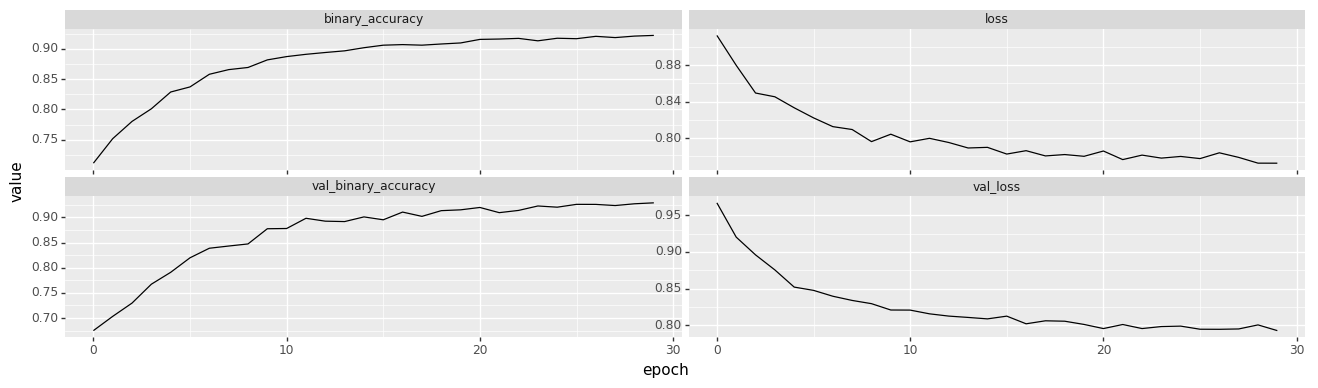

<ggplot: (-9223363272969013381)>

In [590]:
def plot_model_history(history, keys=None, ncol=2, width=8, height=2):
    import plotnine as pn
    import pandas as pd
    import numpy as np
    
    if keys is None:
        keys = sorted(list(history.keys()))
    n = len(keys)
    nrow = int(np.ceil(n / ncol))
    figsize = (ncol * width, nrow * height)
        
    df = pd.concat([
        pd.DataFrame(dict(epoch=list(range(len(h))), value=h)).assign(key=k)
        for k, h in history.items()
    ])
    return (
        pn.ggplot(df, pn.aes(x='epoch', y='value')) +
        pn.geom_line() + 
        pn.facet_wrap('~key', ncol=ncol, scales='free') +
        pn.theme(figure_size=figsize)
    )
    
plot_model_history(history.history)

In [591]:
pred_model = model
#pred_model = keras.models.Model(model.input, keras.layers.Activation('softmax')(model.output))
#pred_model = keras.models.Model(model.input, keras.layers.Activation('sigmoid')(model.output))

In [594]:
#pred_batch = train_batches
X_pred, Y_true = test_generator[0]

In [595]:
Y_pred = model.predict(X_pred)

In [596]:
X_pred.shape, Y_pred.shape, Y_true.shape

((32, 256, 256, 1), (32, 256, 256, 2), (32, 256, 256, 2))

In [597]:
Y_pred.min(), Y_pred.max()

(0.5, 1.0)

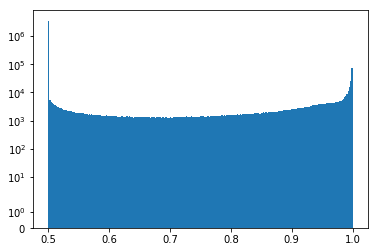

In [598]:
plt.hist(Y_pred.ravel(), bins=248)
ax = plt.gca()
ax.set_yscale('symlog')
None

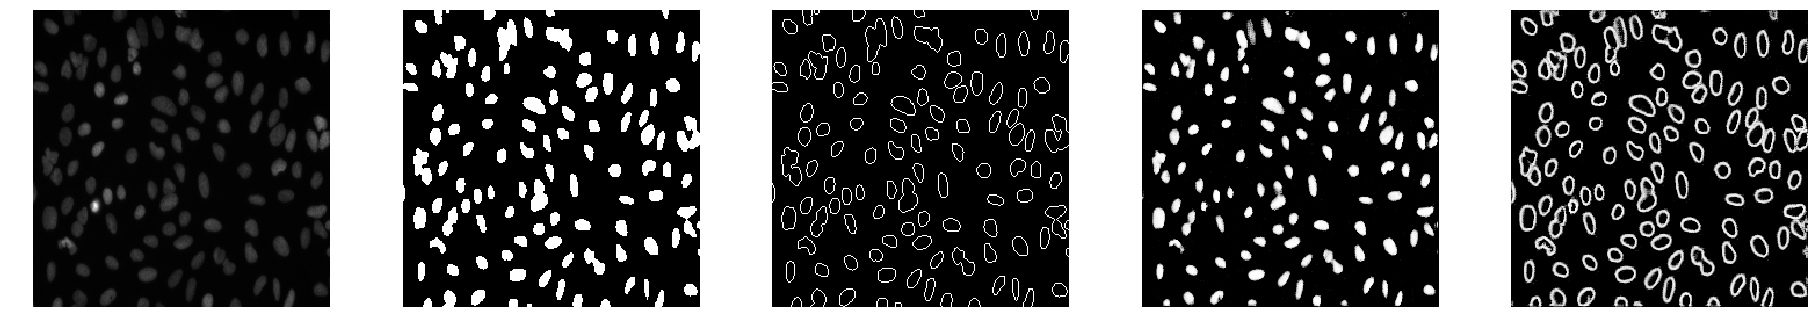

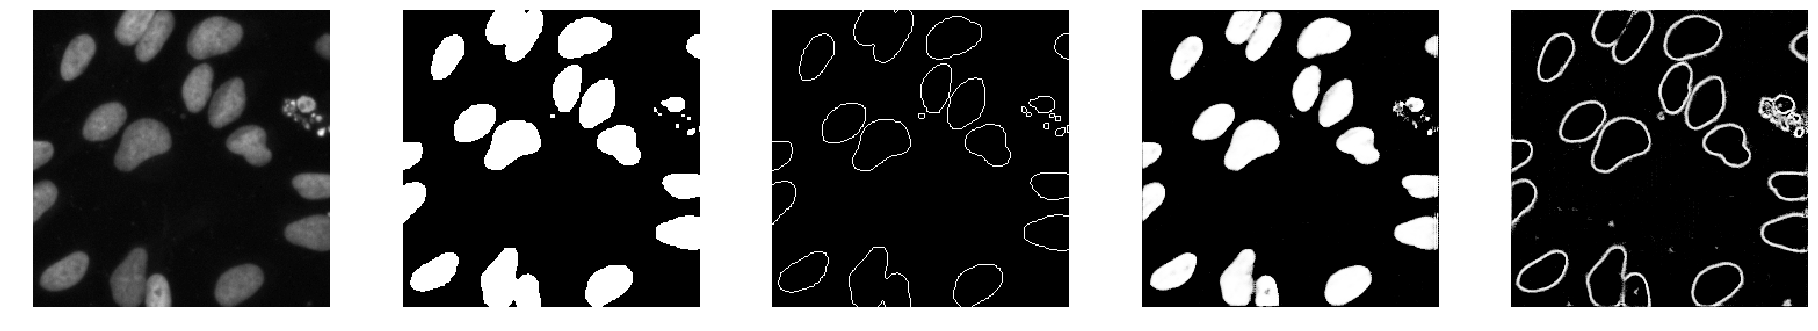

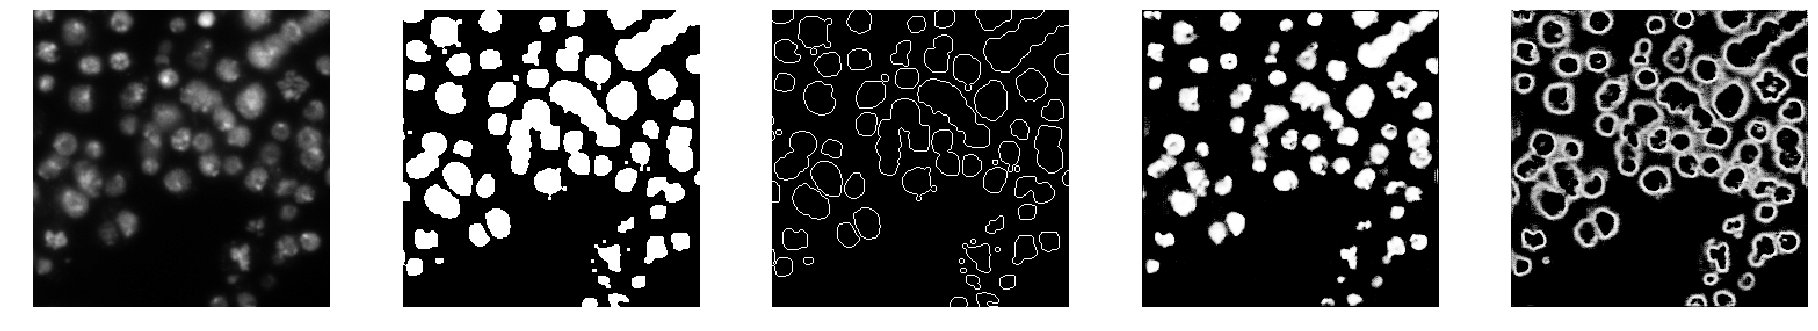

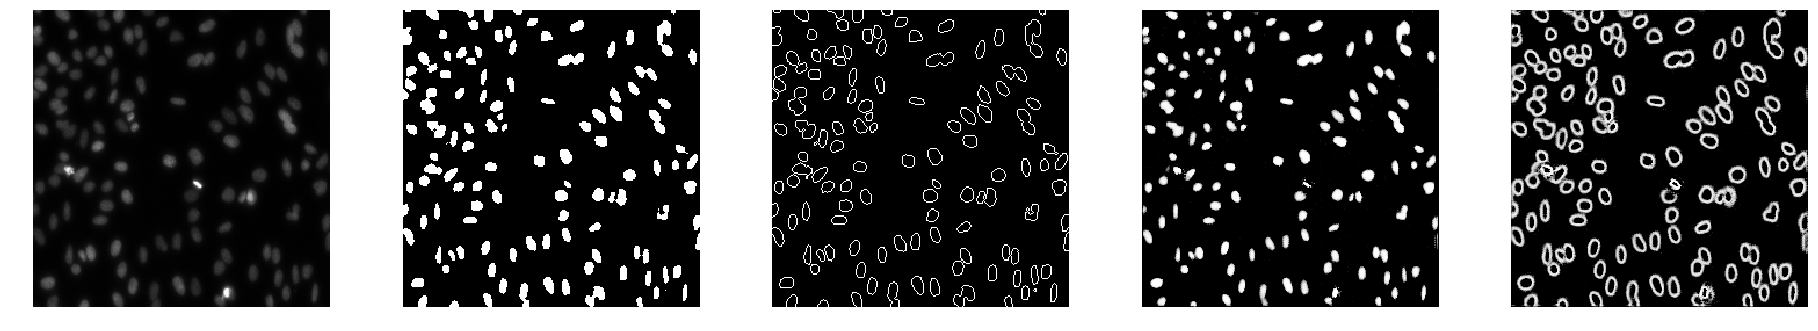

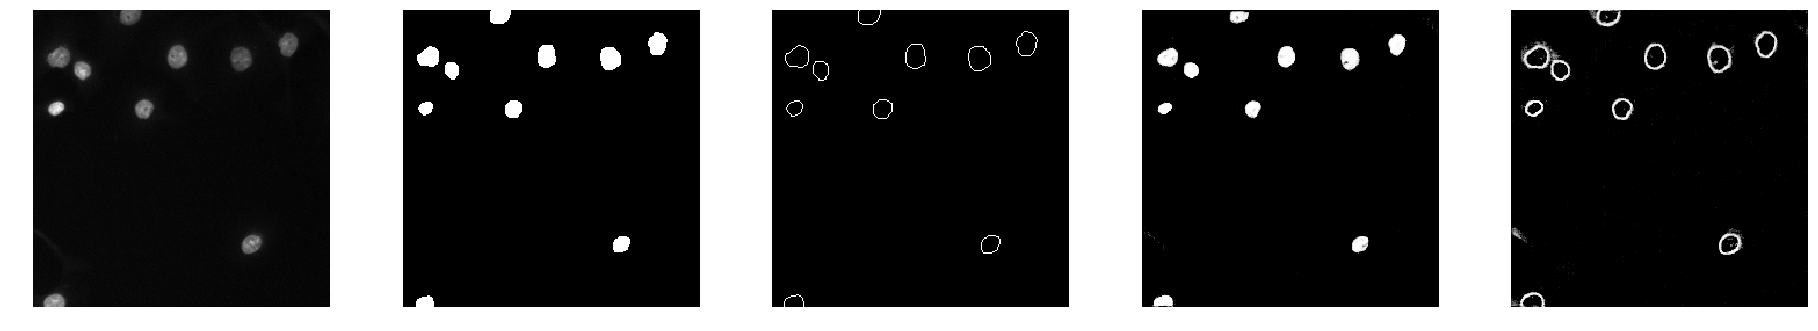

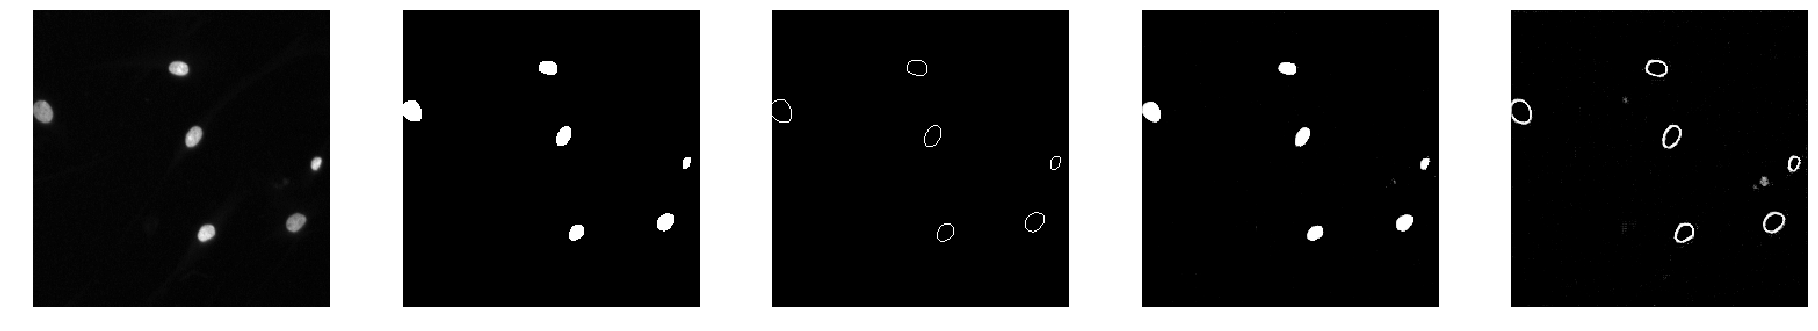

In [601]:
y_chs = [0, 1]
for i in [0, 1, 2, 3, 4, 5]:
    images = []
    images += [X_pred[i, ..., 0]]
    images += [Y_true[i, ..., ch] for ch in y_chs]
    images += [Y_pred[i, ..., ch] for ch in y_chs]
    visualize.display_images(images, size=32, cols=5)